# Проект: Многоцелевая модель для NER + event-CLS

Этот Jupyter-ноутбук - проект по объединённой (multi-task) модели, решающей **NER (BIO, token-level)** и **CLS (document-level multihot событий/отношений)** на датасете NEREL.

## 0. Необходимые импорты


In [1]:
import json
import math
import re
import time
import copy
from collections import Counter
from pathlib import Path
from typing import List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import f1_score, precision_recall_fscore_support

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_

from transformers import (
    AutoTokenizer,
    AutoModel,
    DataCollatorForTokenClassification,
    get_linear_schedule_with_warmup,
)

/home/ubuntu/yandex_practicum_nlp/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. EDA

В EDA смотрю первые 200 записей train для быстрого обзора распределений

In [2]:
# выгружаем первые 200 записей
df = pd.read_json("data/train.jsonl", lines=True, nrows=200)

In [3]:
df.head()

,id,text,entities,relations,links
0,0,"Пулеметы, автоматы и снайперские винтовки изъя...","[T1\tNATIONALITY 62 74\tамериканцами, T2\tCITY...","[R1\tTAKES_PLACE_IN Arg1:T70 Arg2:T12, R2\tAGE...","[N1\tReference T5 Wikidata:Q813\tКиргизия, N2\..."
1,1,Муртаза Рахимов чистит кадры\n\t\nПрезидент Ба...,"[T1\tPERSON 0 15\tМуртаза Рахимов, T2\tPROFESS...","[R1\tWORKS_AS Arg1:T3 Arg2:T76, R2\tWORKS_AS A...","[N1\tReference T9 Wikidata:NULL\t, N2\tReferen..."
2,2,Россия задерживает поставку генсека\n\t\nСегод...,"[T1\tCOUNTRY 0 6\tРоссия, T2\tCITY 48 52\tДохе...","[R1\tALTERNATIVE_NAME Arg1:T4 Arg2:T5, R2\tORG...",[N1\tReference T5 Wikidata:Q1031255\tФорум стр...
3,3,"Российские менеджеры отказались возглавлять ""г...","[T1\tCOUNTRY 0 10\tРоссийские, T2\tORGANIZATIO...","[R1\tALTERNATIVE_NAME Arg1:T80 Arg2:T4, R2\tAL...",[N1\tReference T3 Wikidata:Q6501749\tгенеральн...
4,4,Facebook нашел нового финансового директора\nФ...,"[T1\tORGANIZATION 0 8\tFacebook, T2\tPROFESSIO...","[R1\tAGE_IS Arg1:T6 Arg2:T5, R2\tALTERNATIVE_N...",[N1\tReference T13 Wikidata:Q899140\tGenentech...


In [4]:
# Счетчик кол-ва сущностей
entity_counter = Counter()

for entities in df['entities']:
    entity_counter.update(e.split()[1] for e in entities)

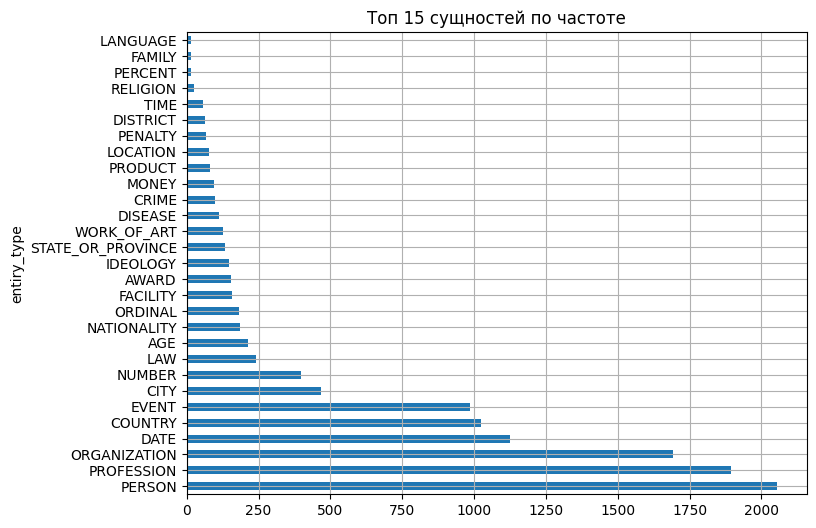

In [5]:
pd.DataFrame( entity_counter.most_common(30), columns=["entiry_type", "cnt"]).plot.barh(
    x="entiry_type",
    y="cnt",
    figsize=(8, 6),
    legend=False,
    grid=True,
    title='Топ 15 сущностей по частоте'
);

In [6]:
# Счетчик кол-ва отношений
relation_counter = Counter()

for relations in df['relations']:
    relation_counter.update(
        r.split("\t")[1].split()[0] for r in relations
    )

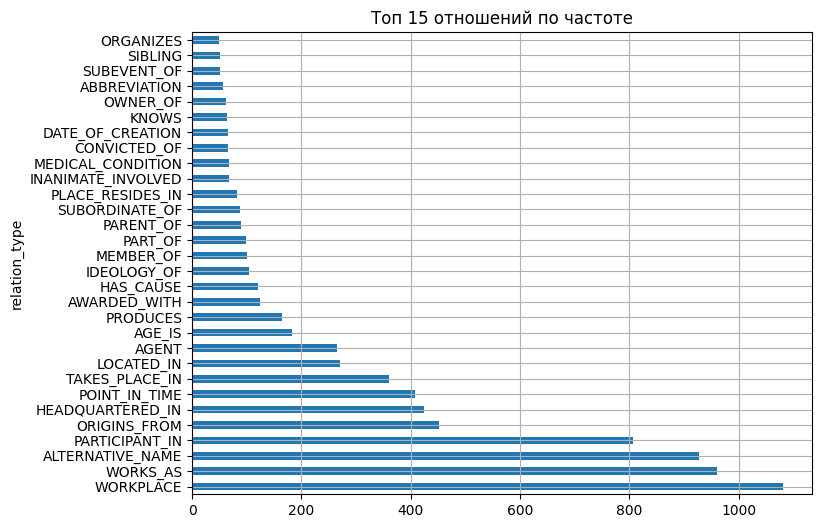

In [7]:
pd.DataFrame(relation_counter.most_common(30), columns=["relation_type", "cnt"]).plot.barh(
    x="relation_type",
    y="cnt",
    figsize=(8, 6),
    legend=False,
    grid=True,
    title='Топ 15 отношений по частоте'
);

In [8]:
df['text_len'] = df['text'].map(len)

Минимальная длина текста: 537
Медианная длина текста: 1484
95% текстов имеют длину в интервале [537, 2872]
Тексты большей длины можно рассматривать как выбросы.


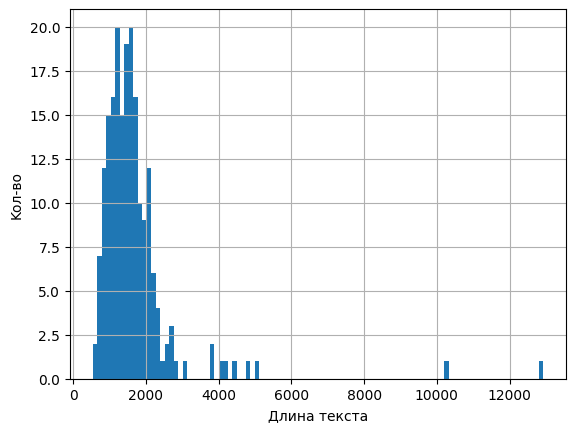

In [9]:
low, high = df['text_len'].quantile([0.0, 0.95])
median = df['text_len'].median()

print(f"Минимальная длина текста: {low:.0f}")
print(f"Медианная длина текста: {median:.0f}")

print(f"95% текстов имеют длину в интервале [{low:.0f}, {high:.0f}]")
print("Тексты большей длины можно рассматривать как выбросы.")


df['text_len'].hist(bins=100)
plt.xlabel("Длина текста")
plt.ylabel("Kол-во");

In [10]:
# кол-во сущностей 
df['cnt_entities'] = df['entities'].map(len)

Минимальное кол-во сущностей: 11
Медианное кол-во сущноестей: 53
95% текстов имеют кол-во сущностей в интервале [11, 113]


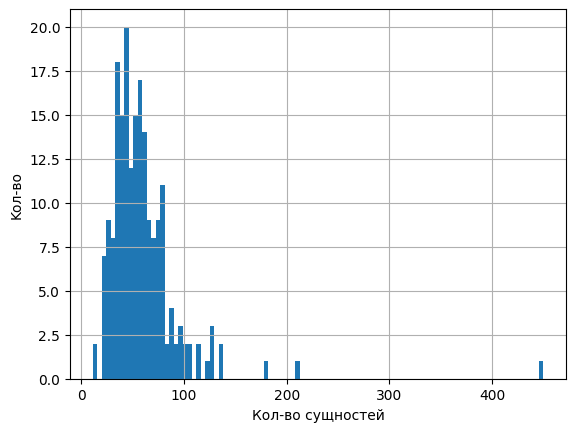

In [11]:
low, high = df['cnt_entities'].quantile([0.0, 0.95])
median = df['cnt_entities'].median()

print(f"Минимальное кол-во сущностей: {low:.0f}")
print(f"Медианное кол-во сущноестей: {median:.0f}")

print(f"95% текстов имеют кол-во сущностей в интервале [{low:.0f}, {high:.0f}]")

df['cnt_entities'].hist(bins=100)
plt.xlabel("Кол-во сущностей")
plt.ylabel("Kол-во");

## Выводы

- Наблюдается сильный дисбаланс по типам сущностей и отношений. Это может привести к тому, что модель будет лучше распознавать частые классы и хуже редкие.
- Большинство документов короче 3000 символов, однако есть и сильные выбросы длиной более 10000. При обучении моделей с ограниченным контекстным окном такие тексты могут требовать усечения или разбиения на части, что потенциально приводит к потере части разметки.
- Число сущностей в большинстве документов менее 110. Но встречаются документы и выбросы на 400+ сущностей. Тексты с высокой плотностью сущностей могут представлять повышенную сложность для модели, так как требуют точного распознавания большого количества сущностей в одном контексте.


## Парсинг и подготовка таргетов

**Правила BIO и сопоставления:**

- Токенизация для BIO - простая `text.split()` (по пробелам). Офсеты токенов вычисляются на основе поиска токена в тексте (учтите повторы; используйте скользящий указатель).
- Для каждой сущности (start, end - символьные оффсеты) пометьте токены, которые пересекаются с интервалом сущности.
- Метки: `B-TYPE`, `I-TYPE`, `O`.



In [12]:
# Функции парсинга строкового формата NEREL
def parse_entity_line(line: str):
    parts = line.split('\t')
    if len(parts) < 3:
        return None
    ent_id = parts[0].strip()
    type_pos = parts[1].strip()
    text = parts[2].strip() if len(parts) > 2 else ''
    m = re.match(r'(\S+)\s+(\d+)\s+(\d+)', type_pos)
    if not m:
        return None
    ent_type = m.group(1)
    start = int(m.group(2))
    end = int(m.group(3))
    return {'id': ent_id, 'type': ent_type, 'start': start, 'end': end, 'text': text}

def parse_relation_line(line: str):
    parts = line.split('\t')
    if len(parts) < 2:
        return None
    rel_id = parts[0].strip()
    body = parts[1].strip()
    m = re.match(r'(\S+)\s+Arg1:(\S+)\s+Arg2:(\S+)', body)
    if not m:
        return None
    rel_type = m.group(1)
    arg1 = m.group(2); arg2 = m.group(3)
    return {'id': rel_id, 'type': rel_type, 'arg1': arg1, 'arg2': arg2}



In [13]:
def get_records(str_path):
    path = Path(str_path)  
    records = []
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            records.append(json.loads(line))
    return records

def parse_entity_and_relations(records):
    for r in records:
        r['entities'] = [parse_entity_line(e) for e in r.get('entities', [])]
        r['relations'] = [parse_relation_line(e) for e in r.get('relations', [])]
    return records



In [14]:
def make_event_list(records, K=None):
    def _get_types(field):
        counter = Counter()
        for r in records:
            for item in r.get(field, []):
                counter[item['type']] += 1

        if K is None:
            return list(counter.keys())
        else:
            return [key for key, _ in counter.most_common(K)]

    return _get_types('relations'), _get_types('entities')

In [15]:
train_records = get_records("data/train.jsonl")
test_records = get_records("data/test.jsonl")

print("Кол-во записий в train:", len(train_records))
print("Кол-во записий в test:", len(test_records))

Кол-во записий в train: 746
Кол-во записий в test: 93


In [16]:
train_records = parse_entity_and_relations(train_records)
test_records = parse_entity_and_relations(test_records)

In [17]:
relations, entities =  make_event_list(train_records)

In [18]:
print(relations[:5])
print(entities[:5])

['TAKES_PLACE_IN', 'AGE_IS', 'HEADQUARTERED_IN', 'ORGANIZES', 'LOCATED_IN']
['NATIONALITY', 'CITY', 'DATE', 'COUNTRY', 'ORGANIZATION']


In [19]:
def build_examples_from_nerel(records: List[dict], event_list: List[str]) -> List[dict]:
    event2idx = {e: i for i, e in enumerate(event_list)}
    examples = []

    for r in records:
        text = r['text']
        tokens = r['text'].split()

        # token_spans
        token_spans = []
        start_from = 0
        for t in tokens:
            span_start = text.find(t, start_from)
            span_end = span_start + len(t)
            token_spans.append((span_start, span_end))
            start_from = span_end
        
        # BIO
        token_labels = ["O"] * len(tokens)

        for ent in r.get("entities", []):
            init_type = ent["type"]
            span_start = ent["start"]
            span_stop = ent["end"]

            pos_ids = []
            for i, (ts0, ts1) in enumerate(token_spans):
                if ts0 < span_stop and ts1 > span_start:
                    pos_ids.append(i)

            if len(pos_ids) == 0:
                continue

            free_ids = [tid for tid in pos_ids if token_labels[tid] == "O"]
            if len(free_ids) == 0:
                continue
            
            token_labels[free_ids[0]] = "B-" + init_type
            for tid in free_ids[1:]:
                token_labels[tid] = "I-" + init_type

        # cls_vec 
        cls_vec = [0] * len(event_list)
        for rel in r.get("relations", []):
            rel_type = rel["type"]
            idx = event2idx.get(rel_type)
            if idx is not None:
                cls_vec[idx] = 1

        examples.append({
            "text": text,
            "tokens": tokens,
            "token_spans": token_spans,
            "tags": token_labels,
            "cls_vec": cls_vec,
        })

    return examples

In [20]:
train_examples = build_examples_from_nerel(train_records, event_list=relations)
test_examples = build_examples_from_nerel(test_records, event_list=relations)

In [21]:
print('Проверка разметки')
top_n = 20
i = 0

for tok, tag in zip(train_examples[i]['tokens'][:top_n], train_examples[i]['tags'][:top_n]):
    print(f"{tok:<20} {tag}")

Проверка разметки
Пулеметы,            O
автоматы             O
и                    O
снайперские          O
винтовки             O
изъяты               O
в                    O
арендуемом           O
американцами         B-NATIONALITY
доме                 O
в                    O
Бишкеке              B-CITY
05/08/2008           B-DATE
10:35                B-TIME
БИШКЕК,              B-CITY
5                    B-DATE
августа              I-DATE
/Новости-Грузия/.    B-COUNTRY
Правоохранительные   B-ORGANIZATION
органы               I-ORGANIZATION


## 3. Токенизация и выравнивание меток

In [22]:
model_name = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

In [23]:
unique_labels = set()
for ex in train_examples:
    unique_labels.update(ex["tags"])
unique_labels.add("O")

label_list = sorted(unique_labels)
label2id = {lab: i for i, lab in enumerate(label_list)}
id2label = {i: lab for lab, i in label2id.items()}

In [24]:
def tokenize_and_align_labels(examples_batch):
    tokenized = tokenizer(
        examples_batch["tokens"],
        is_split_into_words=True,
        truncation=True,
        padding="max_length",
        max_length=123,
        return_offsets_mapping=True,   
    )

    labels = []
    for i, word_labels in enumerate(examples_batch["tags"]):
        word_ids = tokenized.word_ids(batch_index=i)

        label_ids = []
        prev_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif prev_word_idx != word_idx:
                label_ids.append(label2id[word_labels[word_idx]])
            else:
                label_ids.append(-100)
            prev_word_idx = word_idx

        labels.append(label_ids)

    tokenized["labels"] = labels
    tokenized["cls_labels"] = examples_batch["cls_vec"]
    return tokenized


In [25]:
from datasets import Dataset, DatasetDict

dataset = DatasetDict({
    "train": Dataset.from_list(train_examples),
    "test": Dataset.from_list(test_examples),
})

In [26]:
tokenized_dataset = dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=["text", "tokens", "token_spans", "tags", "cls_vec"]
)

Map: 100%|██████████| 93/93 [00:00<00:00, 611.18 examples/s]


In [27]:
print(tokenized_dataset)
print(tokenized_dataset["train"][0].keys())
print(tokenized_dataset["train"][0])

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'labels', 'cls_labels'],
        num_rows: 746
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'labels', 'cls_labels'],
        num_rows: 93
    })
})
dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'labels', 'cls_labels'])
{'input_ids': [101, 524, 63602, 50362, 10292, 117, 541, 94454, 27159, 12202, 549, 558, 19147, 29633, 14354, 88504, 41335, 10648, 10387, 89982, 12202, 543, 40585, 92154, 10227, 12579, 10364, 541, 33930, 15238, 23716, 10508, 44838, 543, 42578, 10205, 10831, 120, 11052, 120, 10203, 10150, 131, 10803, 510, 27735, 40051, 14736, 45224, 14736, 117, 126, 14165, 120, 78718, 12189, 118, 512, 14360, 22685, 120, 119, 524, 86310, 51823, 32229, 42528, 79987, 519, 23312, 14122, 28791, 13248, 37235, 10227, 50080, 543, 44838, 117, 40585, 92154, 10227, 12579, 10364, 77879

In [28]:
data_collator = DataCollatorForTokenClassification(
    tokenizer=tokenizer,
    padding=True
)

def collactor_with_cls(batch):

    cls_labels = torch.tensor(
        [x["cls_labels"] for x in batch],
        dtype=torch.float
    )

    for x in batch:
        x.pop("cls_labels")

    batch = data_collator(batch)
    batch["cls_labels"] = cls_labels
    return batch

In [29]:
train_dataloader = DataLoader(
    tokenized_dataset["train"],
    batch_size=16,
    shuffle=True,
    collate_fn=collactor_with_cls
)

test_dataloader = DataLoader(
    tokenized_dataset["test"],
    batch_size=16,
    shuffle=False,
    collate_fn=collactor_with_cls
)

In [30]:
batch = next(iter(train_dataloader))

print("input_ids shape:", batch["input_ids"].shape)
print("labels shape:   ", batch["labels"].shape)
print("cls_labels in batch:" , "cls_labels" in batch)

input_ids shape: torch.Size([16, 123])
labels shape:    torch.Size([16, 123])
cls_labels in batch: True


In [31]:
labels = batch["labels"]
labels

tensor([[-100,   19, -100,  ..., -100, -100, -100],
        [-100,    3, -100,  ..., -100,   17, -100],
        [-100,   22, -100,  ..., -100,   50, -100],
        ...,
        [-100,   16, -100,  ..., -100, -100, -100],
        [-100,   22, -100,  ...,   41, -100, -100],
        [-100,    8, -100,  ...,   56,   56, -100]])

In [32]:
top_n = 30
i = 0

input_ids = batch["input_ids"][i]
labels_i = batch["labels"][i]

tokens = tokenizer.convert_ids_to_tokens(input_ids)

for tok, lab in zip(tokens[:top_n], labels_i[:top_n]):
    print(f"{tok:<15} {lab}")

[CLS]           -100
Коми            19
##тет           -100
Сен             47
##ата           -100
под             8
##дер           -100
##жал           -100
при             37
##ем            -100
Ч               3
##ерно          -100
##гор           -100
##ии            -100
в               56
НАТО            19
Во              19
##ору           -100
##жён           -100
##ные           -100
силы            47
Ч               3
##ерно          -100
##гор           -100
##ии            -100
Коми            19
##тет           -100
Сен             47
##ата           -100
США             47


In [33]:
train_example = tokenized_dataset["train"][0]

print("cls_labels length:", len(train_example["cls_labels"]))
print("cls_labels:", train_example["cls_labels"][:10])

cls_labels length: 49
cls_labels: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


## 4. Модель: `JointModel` + custom loss (uncertainty weighting)


In [34]:
class JointModel(nn.Module):
    """Joint multi-task модель: NER + multi-label классификация событий (multihot)"""

    def __init__(self, model_name: str, num_token_labels: int, num_cls_labels: int, dropout: float = 0.1, use_uncertainty_weight: bool = False):
        super().__init__()
        self.model = AutoModel.from_pretrained(model_name)
        hidden_size = self.model.config.hidden_size

        self.dropout = nn.Dropout(dropout)
        self.token_cls = nn.Linear(hidden_size, num_token_labels)
        self.cls_cls = nn.Linear(hidden_size, num_cls_labels)

        self.token_loss_fct = nn.CrossEntropyLoss(ignore_index=-100)
        self.cls_loss_fct = nn.BCEWithLogitsLoss()

        self.use_uncertainty_weight = use_uncertainty_weight
        self.log_sigma_token = nn.Parameter(torch.tensor(0.0))
        self.log_sigma_cls = nn.Parameter(torch.tensor(0.0))

    def forward(self, input_ids, attention_mask, token_type_ids=None, labels=None, cls_labels=None):
        outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    token_type_ids=token_type_ids,
                )
        
        last_hidden = outputs.last_hidden_state
        token_logits = self.token_cls(self.dropout(last_hidden))

        cls_repr = last_hidden[:, 0]
        cls_logits = self.cls_cls(self.dropout(cls_repr)) 
        
        loss = None
        token_loss = None
        cls_loss = None
            
        if labels is not None and cls_labels is not None:
            token_loss = self.token_loss_fct(
                token_logits.view(-1, token_logits.size(-1)),
                labels.view(-1)
            )

            cls_loss = self.cls_loss_fct(cls_logits, cls_labels.float())

            if self.use_uncertainty_weight:
                loss_token_term = torch.exp(-2.0 * self.log_sigma_token) * token_loss + self.log_sigma_token
                loss_cls_term = torch.exp(-2.0 * self.log_sigma_cls) * cls_loss + self.log_sigma_cls
                loss = loss_token_term + loss_cls_term
            else:
                loss = token_loss + cls_loss

        return {
        "loss": loss,
        "token_loss": token_loss,
        "cls_loss": cls_loss,
        "token_logits": token_logits,
        "cls_logits": cls_logits,
    }

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [36]:
model = JointModel(
    model_name=model_name,
    num_token_labels=len(label2id),
    num_cls_labels=len(relations),
    dropout=0.1,
    use_uncertainty_weight=True,
).to(device)

Loading weights: 100%|██████████| 199/199 [00:00<00:00, 605.11it/s, Materializing param=pooler.dense.weight]                               
BertModel LOAD REPORT from: bert-base-multilingual-cased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [37]:
batch = next(iter(train_dataloader))
for k in batch:
    batch[k] = batch[k].to(device)

out = model(
    input_ids=batch["input_ids"],
    attention_mask=batch["attention_mask"],
    token_type_ids=batch.get("token_type_ids", None),
    labels=batch["labels"],
    cls_labels=batch["cls_labels"],
)

print(out["token_logits"].shape, out["cls_logits"].shape, out["loss"].item())

torch.Size([16, 123, 57]) torch.Size([16, 49]) 4.539957523345947


## 5. Training / Validation



In [38]:
def evaluate_joint_model(dataloader, model, device, cls_threshold=0.5):
    """
    Считает метрики на dataloader:
    - token_f1_macro: macro F1 по token-level меткам (игнорируем -100)
    - cls_p_micro / cls_r_micro / cls_f1_micro: micro метрики по flatten multihot
    """
    token_true = []
    token_pred = []

    cls_true = []
    cls_pred = []

    model.eval()

    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}

            out = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                token_type_ids=batch.get("token_type_ids"),
                labels=batch["labels"],
                cls_labels=batch["cls_labels"],
            )

            token_preds = torch.argmax(out["token_logits"], dim=-1)  
            labels = batch["labels"]                                

            for i in range(labels.size(0)):
                for j in range(labels.size(1)):
                    t = labels[i, j].item()
                    if t == -100:
                        continue
                    token_true.append(int(t))
                    token_pred.append(int(token_preds[i, j].item()))

            probs = torch.sigmoid(out["cls_logits"])
            preds = (probs >= cls_threshold).long()

            cls_true.append(batch["cls_labels"].detach().cpu().numpy().astype(int))
            cls_pred.append(preds.detach().cpu().numpy().astype(int))

    token_f1 = f1_score(token_true, token_pred, average="macro", zero_division=0)

    cls_true = np.concatenate(cls_true, axis=0).ravel()
    cls_pred = np.concatenate(cls_pred, axis=0).ravel()

    
    cls_precision, cls_recall, cls_f1, _ = precision_recall_fscore_support(
        cls_true, cls_pred, average="micro", zero_division=0
    )

    return {
        "token_f1": float(token_f1),
        "cls_f1_micro": float(cls_f1),
    }


In [39]:
num_epochs = 50
batch_size = 16
learning_rate = 5e-5

accumulation_steps = 2
warmup_ratio = 0.1
grad_clip = 1.0

In [40]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

num_update_steps_per_epoch = math.ceil(len(train_dataloader) / accumulation_steps)
num_training_steps = num_epochs * num_update_steps_per_epoch
num_warmup_steps = int(warmup_ratio * num_training_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

print("update_steps/epoch:", num_update_steps_per_epoch)
print("training_steps:", num_training_steps)
print("warmup_steps:", num_warmup_steps)

update_steps/epoch: 24
training_steps: 1200
warmup_steps: 120


In [41]:
logs = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    n_batches = 0

    optimizer.zero_grad()

    for i, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch + 1}")):
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            token_type_ids=batch.get("token_type_ids"),
            labels=batch["labels"],
            cls_labels=batch["cls_labels"],
        )

        loss = outputs["loss"]
        loss = loss / accumulation_steps
        loss.backward()

        if (i + 1) % accumulation_steps == 0:
            clip_grad_norm_(model.parameters(), grad_clip)

            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        total_loss += loss.item() * accumulation_steps
        n_batches += 1

    if n_batches % accumulation_steps != 0:
        clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    avg_loss = total_loss / n_batches if n_batches > 0 else 0.0


    metrics = evaluate_joint_model(
        dataloader=test_dataloader,
        model=model,
        device=device,
        cls_threshold=0.5,
    )

    logs.append({
        "epoch": epoch + 1,
        "train_loss": avg_loss,
        "token_f1": metrics["token_f1"],
        "cls_f1_micro": metrics["cls_f1_micro"],
    })

    print(
        f"Epoch {epoch + 1}: "
        f"loss={avg_loss:.4f}, "
        f"token_f1={metrics['token_f1']:.4f}, "
        f"cls_f1_micro={metrics['cls_f1_micro']:.4f}"
    )

Epoch 1: 100%|██████████| 47/47 [00:15<00:00,  3.08it/s]


Epoch 1: loss=4.0362, token_f1=0.0116, cls_f1_micro=0.6180


Epoch 2: 100%|██████████| 47/47 [00:15<00:00,  3.12it/s]


Epoch 2: loss=2.6743, token_f1=0.0881, cls_f1_micro=0.8190


Epoch 3: 100%|██████████| 47/47 [00:15<00:00,  3.11it/s]


Epoch 3: loss=1.6805, token_f1=0.2244, cls_f1_micro=0.8249


Epoch 4: 100%|██████████| 47/47 [00:15<00:00,  3.07it/s]


Epoch 4: loss=1.1718, token_f1=0.4033, cls_f1_micro=0.8251


Epoch 5: 100%|██████████| 47/47 [00:15<00:00,  3.06it/s]


Epoch 5: loss=0.8944, token_f1=0.4751, cls_f1_micro=0.8258


Epoch 6: 100%|██████████| 47/47 [00:15<00:00,  3.04it/s]


Epoch 6: loss=0.7366, token_f1=0.5270, cls_f1_micro=0.8321


Epoch 7: 100%|██████████| 47/47 [00:15<00:00,  3.02it/s]


Epoch 7: loss=0.6164, token_f1=0.5842, cls_f1_micro=0.8402


Epoch 8: 100%|██████████| 47/47 [00:15<00:00,  3.00it/s]


Epoch 8: loss=0.5456, token_f1=0.6177, cls_f1_micro=0.8409


Epoch 9: 100%|██████████| 47/47 [00:15<00:00,  3.00it/s]


Epoch 9: loss=0.4944, token_f1=0.6188, cls_f1_micro=0.8433


Epoch 10: 100%|██████████| 47/47 [00:15<00:00,  2.99it/s]


Epoch 10: loss=0.4511, token_f1=0.6172, cls_f1_micro=0.8440


Epoch 11: 100%|██████████| 47/47 [00:15<00:00,  2.97it/s]


Epoch 11: loss=0.4115, token_f1=0.6603, cls_f1_micro=0.8451


Epoch 12: 100%|██████████| 47/47 [00:15<00:00,  2.96it/s]


Epoch 12: loss=0.3837, token_f1=0.6293, cls_f1_micro=0.8490


Epoch 13: 100%|██████████| 47/47 [00:16<00:00,  2.94it/s]


Epoch 13: loss=0.3600, token_f1=0.6831, cls_f1_micro=0.8473


Epoch 14: 100%|██████████| 47/47 [00:16<00:00,  2.90it/s]


Epoch 14: loss=0.3391, token_f1=0.6582, cls_f1_micro=0.8477


Epoch 15: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 15: loss=0.3168, token_f1=0.6830, cls_f1_micro=0.8488


Epoch 16: 100%|██████████| 47/47 [00:15<00:00,  2.94it/s]


Epoch 16: loss=0.3003, token_f1=0.6833, cls_f1_micro=0.8506


Epoch 17: 100%|██████████| 47/47 [00:15<00:00,  2.94it/s]


Epoch 17: loss=0.2813, token_f1=0.6816, cls_f1_micro=0.8521


Epoch 18: 100%|██████████| 47/47 [00:15<00:00,  2.94it/s]


Epoch 18: loss=0.2650, token_f1=0.6686, cls_f1_micro=0.8492


Epoch 19: 100%|██████████| 47/47 [00:16<00:00,  2.94it/s]


Epoch 19: loss=0.2541, token_f1=0.6600, cls_f1_micro=0.8510


Epoch 20: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 20: loss=0.2406, token_f1=0.6601, cls_f1_micro=0.8495


Epoch 21: 100%|██████████| 47/47 [00:16<00:00,  2.94it/s]


Epoch 21: loss=0.2281, token_f1=0.6842, cls_f1_micro=0.8503


Epoch 22: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 22: loss=0.2157, token_f1=0.6675, cls_f1_micro=0.8512


Epoch 23: 100%|██████████| 47/47 [00:15<00:00,  2.94it/s]


Epoch 23: loss=0.2042, token_f1=0.6795, cls_f1_micro=0.8506


Epoch 24: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 24: loss=0.1942, token_f1=0.6826, cls_f1_micro=0.8492


Epoch 25: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 25: loss=0.1851, token_f1=0.6790, cls_f1_micro=0.8554


Epoch 26: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 26: loss=0.1748, token_f1=0.6872, cls_f1_micro=0.8506


Epoch 27: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 27: loss=0.1666, token_f1=0.6888, cls_f1_micro=0.8497


Epoch 28: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 28: loss=0.1562, token_f1=0.6851, cls_f1_micro=0.8523


Epoch 29: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 29: loss=0.1484, token_f1=0.6702, cls_f1_micro=0.8506


Epoch 30: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 30: loss=0.1413, token_f1=0.6759, cls_f1_micro=0.8501


Epoch 31: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 31: loss=0.1357, token_f1=0.6755, cls_f1_micro=0.8514


Epoch 32: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 32: loss=0.1283, token_f1=0.6672, cls_f1_micro=0.8479


Epoch 33: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 33: loss=0.1213, token_f1=0.6776, cls_f1_micro=0.8508


Epoch 34: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 34: loss=0.1159, token_f1=0.6703, cls_f1_micro=0.8510


Epoch 35: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 35: loss=0.1094, token_f1=0.6713, cls_f1_micro=0.8501


Epoch 36: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 36: loss=0.1037, token_f1=0.6699, cls_f1_micro=0.8470


Epoch 37: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 37: loss=0.0992, token_f1=0.6787, cls_f1_micro=0.8481


Epoch 38: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 38: loss=0.0965, token_f1=0.6864, cls_f1_micro=0.8492


Epoch 39: 100%|██████████| 47/47 [00:16<00:00,  2.92it/s]


Epoch 39: loss=0.0915, token_f1=0.6855, cls_f1_micro=0.8473


Epoch 40: 100%|██████████| 47/47 [00:16<00:00,  2.89it/s]


Epoch 40: loss=0.0879, token_f1=0.6803, cls_f1_micro=0.8479


Epoch 41: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 41: loss=0.0852, token_f1=0.6871, cls_f1_micro=0.8475


Epoch 42: 100%|██████████| 47/47 [00:16<00:00,  2.92it/s]


Epoch 42: loss=0.0823, token_f1=0.6815, cls_f1_micro=0.8492


Epoch 43: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 43: loss=0.0787, token_f1=0.6803, cls_f1_micro=0.8506


Epoch 44: 100%|██████████| 47/47 [00:16<00:00,  2.92it/s]


Epoch 44: loss=0.0753, token_f1=0.6857, cls_f1_micro=0.8490


Epoch 45: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 45: loss=0.0746, token_f1=0.6853, cls_f1_micro=0.8486


Epoch 46: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 46: loss=0.0729, token_f1=0.6874, cls_f1_micro=0.8488


Epoch 47: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 47: loss=0.0707, token_f1=0.6801, cls_f1_micro=0.8481


Epoch 48: 100%|██████████| 47/47 [00:16<00:00,  2.92it/s]


Epoch 48: loss=0.0706, token_f1=0.6807, cls_f1_micro=0.8497


Epoch 49: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 49: loss=0.0689, token_f1=0.6804, cls_f1_micro=0.8495


Epoch 50: 100%|██████████| 47/47 [00:16<00:00,  2.93it/s]


Epoch 50: loss=0.0689, token_f1=0.6800, cls_f1_micro=0.8501


In [42]:
log_df = pd.DataFrame(logs)
log_df.tail()

,epoch,train_loss,token_f1,cls_f1_micro
45,46,0.072865,0.687405,0.848804
46,47,0.070709,0.680125,0.848146
47,48,0.070646,0.680749,0.849682
48,49,0.068939,0.680389,0.849462
49,50,0.068903,0.680045,0.850121


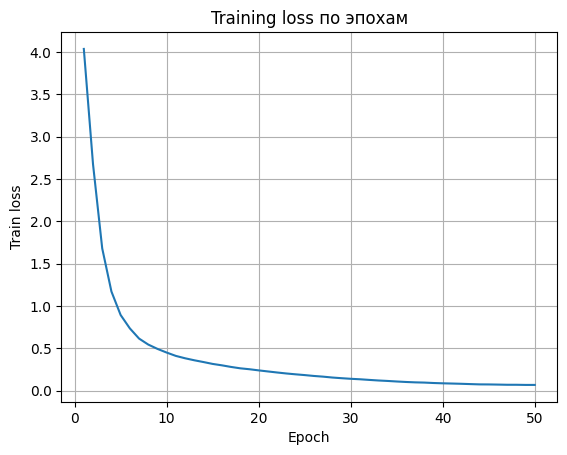

In [43]:
plt.figure()
plt.plot(log_df["epoch"], log_df["train_loss"])
plt.xlabel("Epoch")
plt.ylabel("Train loss")
plt.title("Training loss по эпохам")
plt.grid(True)
plt.show();

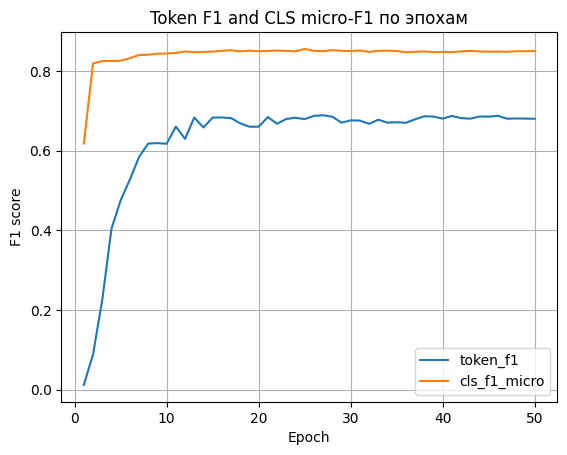

In [44]:
plt.figure()
plt.plot(log_df["epoch"], log_df["token_f1"], label="token_f1")
plt.plot(log_df["epoch"], log_df["cls_f1_micro"], label="cls_f1_micro")
plt.xlabel("Epoch")
plt.ylabel("F1 score")
plt.title("Token F1 and CLS micro-F1 по эпохам")
plt.legend()
plt.grid(True)
plt.show()

In [45]:
log_df.head()

,epoch,train_loss,token_f1,cls_f1_micro
0,1,4.036229,0.011582,0.617950
1,2,2.674279,0.088105,0.818960
2,3,1.680462,0.224441,0.824885
3,4,1.171815,0.403329,0.825104
4,5,0.894375,0.475098,0.825763


#### Кратко про метрики

**cls_micro_f1** выходит на плато уже на ранних этапах обучения и в дальнейшем практически не меняется. Это может быть связано с несколькими факторами:

1) Как мы видели в секции EDA - у нас сильный дисбаланс отношений в задаче классификации. В данных доля отрицательных меток существенно превышает долю положительных, поэтому даже относительно небольшие изменения в предсказаниях по редким классам слабо отражаются на итоговом значении

2) Задача классификации является более простой по сравнению с NER: модель достаточно быстро обучается распознавать общие признаки событий и отношений на уровне всего текста. Поэтому модель быстро достигает предела качества и дальнейшее обучение на дает роста метрики


**token_f1** до 10 эпохи растет очень быстро. После рост метрики замедляется и примерно к 15 эпохе выходит на плато с колебаниями в районе ~0.7.

## 6. Инференс, квантизация и анализ ошибок

In [46]:
def pred_from_text(text, model, tokenizer, device, id2label, id2relation, topk=10, max_length=128):
    tokens = text.split()

    enc = tokenizer(
        tokens,
        is_split_into_words=True,
        truncation=True,
        padding="max_length",
        max_length=max_length,
        return_tensors="pt",
    )

    word_ids = enc.word_ids(batch_index=0)
    enc = {k: v.to(device) for k, v in enc.items()}

    model.eval()
    with torch.no_grad():
        out = model(
            input_ids=enc["input_ids"],
            attention_mask=enc["attention_mask"],
            token_type_ids=enc.get("token_type_ids", None),
            labels=None,
            cls_labels=None,
        )

        token_logits = out["token_logits"][0]
        pred_ids = torch.argmax(token_logits, dim=-1).detach().cpu().tolist()

        cls_logits = out["cls_logits"][0]
        cls_probs = torch.sigmoid(cls_logits).detach().cpu().numpy()

    # word-level BIO
    bio_pred = []
    seen = set()
    for tok_i, w_id in enumerate(word_ids):
        if w_id is None or w_id in seen:
            continue
        seen.add(w_id)
        bio_pred.append(id2label[int(pred_ids[tok_i])])

    L = min(len(tokens), len(bio_pred))
    tokens = tokens[:L]
    bio_pred = bio_pred[:L]

    # CLS
    pred_idx = np.where(cls_probs >= 0.5)[0]
    cls_pred_relations = sorted(
        [(id2relation[int(i)], float(cls_probs[int(i)])) for i in pred_idx],
        key=lambda x: x[1],
        reverse=True,
    )

    return {
        "text": text,
        "tokens": tokens,
        "bio_pred": bio_pred,
        "cls_probs": cls_probs,
        "cls_pred_relations": cls_pred_relations    
        }


In [47]:
id2relation = {i: r for i, r in enumerate(relations)}

In [48]:
def res_test_example(test_example, model, tokenizer, device, id2label, id2relation):
    sample_text = test_example["text"]

    pred = pred_from_text(
        text=sample_text,
        model=model,
        tokenizer=tokenizer,
        device=device,
        id2label=id2label,
        id2relation=id2relation
    )

    L = min(len(test_example["tokens"]), len(test_example["tags"]), len(pred["tokens"]), len(pred["bio_pred"]))

    pred_ner_df = pd.DataFrame({
        "token": test_example["tokens"][:L],
        "real_tag": test_example["tags"][:L],
        "pred_tag": pred["bio_pred"][:L],
    })

    pred_ner_df["is_error"] = pred_ner_df["real_tag"] != pred_ner_df["pred_tag"]


    real_rel = [id2relation[i] for i, v in enumerate(test_example["cls_vec"]) if v == 1]

    pred_rel_df = pd.DataFrame(pred["cls_pred_relations"], columns=["pred_rel", "p"])
    pred_rel_df["is_true"] = pred_rel_df["pred_rel"].map(lambda x: x in real_rel)

    pred_rel_set = set(pred_rel_df["pred_rel"].tolist())
    missed_real_rel = sorted([r for r in real_rel if r not in pred_rel_set])

    return pred_ner_df, pred_rel_df, missed_real_rel

In [49]:
for i in range(9):
    test_example = test_examples[i]
    pred_ner_df, pred_rel_df, missed_real_rel = res_test_example(
    test_example=test_example,
    model=model,
    tokenizer=tokenizer,
    device=device,
    id2label=id2label,
    id2relation=id2relation)

    print(f'-------------{i}-----------')
    print(pred_ner_df.query("is_error"))
    print()
    print("Пропущенные моделью отношения: ", missed_real_rel)
    print(pred_rel_df)
    print()

-------------0-----------
     token real_tag  pred_tag  is_error
28  "1+1",        O  B-NUMBER      True
49       в   B-DATE         O      True

Пропущенные моделью отношения:  ['AWARDED_WITH']
            pred_rel         p  is_true
0           WORKS_AS  0.994101     True
1   ALTERNATIVE_NAME  0.993158     True
2          WORKPLACE  0.988285     True
3     PARTICIPANT_IN  0.970400     True
4   HEADQUARTERED_IN  0.921094     True
5       ORIGINS_FROM  0.891161     True
6             AGE_IS  0.820400     True
7              AGENT  0.692576     True
8     TAKES_PLACE_IN  0.609287     True
9      POINT_IN_TIME  0.580280    False
10           PART_OF  0.541376    False
11       SUBEVENT_OF  0.515188    False

-------------1-----------
           token    real_tag        pred_tag  is_error
33  Центрального  I-FACILITY  B-ORGANIZATION      True
34         банка  I-FACILITY  I-ORGANIZATION      True
35           РФ.  I-FACILITY  I-ORGANIZATION      True
47            на           O         

На таком небольшом количестве примеров сложно делать какие-то устойчивые выводы, но по ручному разбору видно несколько повторяющихся типов ошибок.

- В NER модель чаще всего путает близкие по смыслу теги: в первую очередь TIME/DATE, а также CITY/LOCATION/DISTRICT и PROFESSION/ORGANIZATION. 
- Довольно много ошибок связано с границами сущностей: смешение B и I тегов, частичные захваты многословных сущностей. Также встречаются ложные срабатывания на O токенах, когда модель достраивает сущность там, где её нет.

- По отношениям видно, что модель лучше всего справляется с базовыми и часто встречающимися связями (WORKPLACE, WORKS_AS, PARTICIPANT_IN, TAKES_PLACE_IN, POINT_IN_TIME). При этом более редкие или контекстно сложные отношения часто пропускаются. 

В целом ручной анализ позволяет понять характер ошибок, но не даёт возможности количественно оценить, какие теги и отношения являются самыми проблемными. Поэтому дальше имеет смысл сделать агрегированную статистику по всему тестовому датасету, чтобы подтвердить эти наблюдения и точнее определить слабые места модели.

### Соберем статистику по всем тэгам и отношениям в тестовом датасете

Соберём агрегированную статистику по всем тэгам и отношениям на тестовом датасете.
- Для NER построим confusion matrix по токенам, чтобы понять, какие тэги модель чаще всего путает между собой, а также оценим recall по каждому тэгу.
- Для отношений рассмотрим стандартные метрики классификации (precision, recall, f1) для каждого отношения, чтобы увидеть, какие отношения модель предсказывает хорошо, а какие хуже.

In [50]:
ner_rows = []          
rel_counts = {}        
rel_conf_rows = []    

for example_id, ex in enumerate(test_examples):
    pred_ner_df, pred_rel_df, _ = res_test_example(
        test_example=ex,
        model=model,
        tokenizer=tokenizer,
        device=device,
        id2label=id2label,
        id2relation=id2relation
    )

    # NER: сохраняем пары (real_tag, pred_tag)
    ner_part = pred_ner_df[["token", "real_tag", "pred_tag"]].copy()
    ner_part["example_id"] = example_id
    ner_rows.append(ner_part)

    # Relations: реальные и предсказанные отношения
    real_rel = {
        id2relation[i]
        for i, v in enumerate(ex["cls_vec"])
        if v == 1
    }
    pred_rel = set(pred_rel_df["pred_rel"].tolist())

    # Обновляем счётчики TP/FP/FN
    all_relations_in_example = real_rel | pred_rel
    for rel in all_relations_in_example:
        if rel not in rel_counts:
            rel_counts[rel] = {"tp": 0, "fp": 0, "fn": 0}

        is_pred = rel in pred_rel
        is_real = rel in real_rel

        if is_pred and is_real:
            rel_counts[rel]["tp"] += 1
        elif is_pred and not is_real:
            rel_counts[rel]["fp"] += 1
        elif (not is_pred) and is_real:
            rel_counts[rel]["fn"] += 1

In [51]:
pairs_df = pd.concat(ner_rows, ignore_index=True)

labels = sorted(set(pairs_df["real_tag"]).union(set(pairs_df["pred_tag"])))

cm = (
    pd.crosstab(pairs_df["real_tag"], pairs_df["pred_tag"])
      .reindex(index=labels, columns=labels, fill_value=0)
)

In [52]:
# из cm соберем статистику по полноте и наиболее частым путаницам в тэгах

def ner_recall_and_top_confusions(cm, top_k=3):

    rows = []
    labels = list(cm.index)

    for real_tag in labels:
        row = cm.loc[real_tag]

        cnt_real = int(row.sum())
        tp = int(row.get(real_tag, 0))
        recall = tp / cnt_real if cnt_real > 0 else np.nan

        err = row.copy()
        if real_tag in err.index:
            err.loc[real_tag] = 0

        top = err.sort_values(ascending=False).head(top_k)

        out = {
            "real_tag": real_tag,
            "cnt_real": cnt_real,
            "tp": tp,
            "recall": recall,
        }

        for k in range(1, top_k + 1):
            if k <= len(top):
                conf_tag = top.index[k - 1]
                conf_cnt = int(top.iloc[k - 1])
                out[f"top_{k}_conf_tag"] = conf_tag if conf_cnt > 0 else np.nan
                out[f"top_{k}_conf_cnt"] = conf_cnt if conf_cnt > 0 else 0
            else:
                out[f"top_{k}_conf_tag"] = np.nan
                out[f"top_{k}_conf_cnt"] = 0

        rows.append(out)

    res = pd.DataFrame(rows)
    return res.sort_values("cnt_real", ascending=False).reset_index(drop=True)


In [53]:
ner_summary = ner_recall_and_top_confusions(cm, top_k=3)
ner_summary.head(15)

,real_tag,cnt_real,tp,recall,top_1_conf_tag,top_1_conf_cnt,top_2_conf_tag,top_2_conf_cnt,top_3_conf_tag,top_3_conf_cnt
0,O,2475,2281,0.921616,B-EVENT,48,I-EVENT,32,B-PROFESSION,19
1,B-PERSON,329,323,0.981763,B-PRODUCT,3,B-WORK_OF_ART,1,B-AWARD,1
2,I-DATE,320,315,0.984375,B-DATE,3,I-TIME,1,O,1
3,I-PERSON,295,293,0.993220,I-AWARD,1,O,1,NaN,0
4,B-EVENT,272,217,0.797794,O,30,I-EVENT,11,B-ORGANIZATION,4
5,B-PROFESSION,242,199,0.822314,O,12,I-PROFESSION,8,B-COUNTRY,6
6,B-DATE,144,127,0.881944,I-DATE,8,O,8,B-EVENT,1
7,I-EVENT,144,93,0.645833,O,29,I-DISEASE,5,B-EVENT,5
8,B-ORGANIZATION,141,109,0.773050,I-ORGANIZATION,9,I-PROFESSION,5,O,4
9,B-COUNTRY,122,101,0.827869,B-NATIONALITY,14,I-PROFESSION,3,I-ORGANIZATION,2


In [54]:
rel_rows = []
for rel, c in rel_counts.items():
    tp, fp, fn = c["tp"], c["fp"], c["fn"]

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall    = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1        = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0.0

    rel_rows.append({
        "relation": rel,
        "tp": tp, "fp": fp, "fn": fn,
        "precision": precision,
        "recall": recall,
        "f1": f1
    })

rel_metrics = pd.DataFrame(rel_rows).sort_values(["f1", "tp"], ascending=[False, False])

In [58]:
rel_metrics.head(40)

,relation,tp,fp,fn,precision,recall,f1
12,ALTERNATIVE_NAME,87,6,0,0.935484,1.000000,0.966667
1,PARTICIPANT_IN,82,7,3,0.921348,0.964706,0.942529
9,WORKS_AS,81,12,0,0.870968,1.000000,0.931034
6,POINT_IN_TIME,71,15,6,0.825581,0.922078,0.871166
8,TAKES_PLACE_IN,63,12,8,0.840000,0.887324,0.863014
4,AGE_IS,59,13,7,0.819444,0.893939,0.855072
0,WORKPLACE,65,20,3,0.764706,0.955882,0.849673
18,AGE_DIED_AT,13,4,1,0.764706,0.928571,0.838710
3,HEADQUARTERED_IN,55,16,7,0.774648,0.887097,0.827068
25,DATE_OF_DEATH,11,2,3,0.846154,0.785714,0.814815


После агрегации по всему тестовому датасету картина становится яснее.

По NER в целом модель работает стабильно: у большинства частотных тегов recall выше 0.80. Лучше всего распознаются PERSON, DATE — там ошибки единичные и в основном связаны с границами сущностей. При этом явно проблемными остаются I-теги, особенно I-PROFESSION и I-EVENT: у них самый низкий recall, и чаще всего они путаются либо с O, либо с организационными тегами. Это подтверждает наблюдение из ручного анализа.

Отдельно видно, что для B-EVENT и I-EVENT модель регулярно либо пропускает сущность, либо путает B и I между собой, что указывает на слабое обучение именно событийных сущностей. Также сохраняется путаница между PROFESSION и ORGANIZATION, особенно на внутренних токенах.

По классификации отношений распределение качества сильно неравномерное. Небольшое число базовых отношений (ALTERNATIVE_NAME, PARTICIPANT_IN, WORKS_AS, POINT_IN_TIME, TAKES_PLACE_IN) имеют высокий recall и хороший f1, модель уверенно их находит и редко пропускает. 

Дальше видно резкое падение качества: у значительной части отношений recall ниже 0.5, а у некоторых он практически нулевой. Это в основном редкие отношения.

В итоге агрегированная статистика подтверждает выводы из ручного анализа: модель уверенно покрывает основные, частотные сценарии, но теряет качество на длинных сущностях, I-тегах и редких отношениях. Это указывает на основные направления для улучшения: усиление обучения границ сущностей и балансировка/дообучение редких relations.

## Квантизация

In [56]:
# качество  и скорость сравниваем на CPU
device_eval = "cpu"
cls_threshold = 0.5

model_fp32 = copy.deepcopy(model).cpu().eval()

model_int8 = torch.quantization.quantize_dynamic(
    model_fp32,
    {nn.Linear},
    dtype=torch.qint8
).eval()

def eval_with_time(model_to_eval, tag):
    t0 = time.perf_counter()

    metrics = evaluate_joint_model(
        dataloader=test_dataloader,
        model=model_to_eval,
        device=device_eval,
        cls_threshold=cls_threshold,
    )

    t1 = time.perf_counter()

    return {
        "model": tag,
        "token_f1": metrics["token_f1"],
        "cls_f1_micro": metrics["cls_f1_micro"],
        "eval_time_sec": t1 - t0,
    }

res_fp32 = eval_with_time(model_fp32, "fp32")
res_int8 = eval_with_time(model_int8, "int8_dynamic")

cmp = pd.DataFrame([res_fp32, res_int8])

/tmp/ipykernel_15789/2039252030.py:7: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_int8 = torch.quantization.quantize_dynamic(


In [57]:
cmp

,model,token_f1,cls_f1_micro,eval_time_sec
0,fp32,0.680045,0.850121,9.181475
1,int8_dynamic,0.670872,0.845074,4.820560


После динамической квантизации модели (int8) наблюдается заметное ускорение инференса: время полного прогона тестового датасета сократилось более чем в два раза по сравнению с fp32-версией.

При этом качество немного просело. token_f1 снизился, что ожидаемо, так как NER более чувствителен к квантизации. cls_f1_micro изменился незначительно и остался практически на том же уровне, что и у базовой модели.

Таким образом, dynamic int8 квантизация даёт существенный выигрыш по скорости при небольшой потере качества, в основном за счёт NER-части, и может быть оправдана в сценариях, где скорость инференса важнее максимальной точности.